# FORECAST OF RETAIL LIQUOR SALES

# ARIMA MODEL

In [4]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")



In [122]:
# load DataSet
df = pd.read_csv('../Data/co2_mm_mlo.csv')

In [123]:
df.head()

,year,month,decimal_date,average,interpolated
0,1958,3,1958.208,315.71,315.71
1,1958,4,1958.292,317.45,317.45
2,1958,5,1958.375,317.50,317.50
3,1958,6,1958.458,NaN,317.10
4,1958,7,1958.542,315.86,315.86


In [7]:
# Add a "date" datetime column
df['date']=pd.to_datetime(dict(year=df['year'], month=df['month'], day=1))

In [8]:
df.set_index('date',inplace=True)
df.index.freq = 'MS'
df.head()

,year,month,decimal_date,average,interpolated
date,,,,,
1958-03-01,1958,3,1958.208,315.71,315.71
1958-04-01,1958,4,1958.292,317.45,317.45
1958-05-01,1958,5,1958.375,317.50,317.50
1958-06-01,1958,6,1958.458,NaN,317.10
1958-07-01,1958,7,1958.542,315.86,315.86


## Plot the Dataset

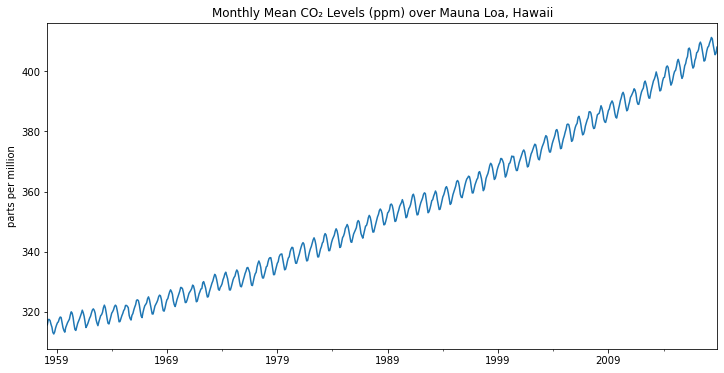

In [9]:
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel='' # we don't really need a label here

ax = df['interpolated'].plot(figsize=(12,6),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

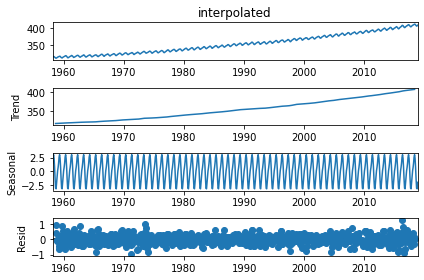

In [10]:
result = seasonal_decompose(df['interpolated'], model='add')
result.plot();

In [11]:
# For SARIMA Orders we set seasonal=True and pass in an m value
auto_arima(df['interpolated'],seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  729
Model:             SARIMAX(0, 1, 3)x(1, 0, [1], 12)   Log Likelihood                -205.701
Date:                              Mon, 25 Oct 2021   AIC                            423.401
Time:                                      17:13:36   BIC                            450.943
Sample:                                           0   HQIC                           434.028
                                              - 729                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3560      0.035    -10.073      0.000      -0.425      -0.287
ma.L2         -0.0224      0.028     -0.792      0.428      -0.078       0.033
ma.L3         -0.0861      0.028     -3.042      0.002      -0.142      -0.031
ar.S.L12       0.9996      0.000   2870.137      0.000       0.999       1.000
ma.S.L12      -0.8653      0.021    -40.475      0.000      -0.907      -0.823
sigma2         0.0956      0.005     20.324      0.000       0.086       0.105
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 3.99
Prob(Q):                              0.79   Prob(JB):                         0.14
Heteroskedasticity (H):               1.13   Skew:                             0.00
Prob(H) (two-sided):                  0.34   Kurtosis:                         3.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Split the data into train/test sets

In [12]:
len(df)

729

In [13]:
# Set one year for testing
train = df.iloc[:717]
test = df.iloc[717:]

### Fit a SARIMA(0,1,3)(1,0,1,12) Model

In [14]:
model = SARIMAX(train['interpolated'],order=(0,1,3),seasonal_order=(1,0,1,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                         interpolated   No. Observations:                  717
Model:             SARIMAX(0, 1, 3)x(1, 0, [1], 12)   Log Likelihood                -201.189
Date:                              Mon, 25 Oct 2021   AIC                            414.378
Time:                                      17:14:40   BIC                            441.820
Sample:                                  03-01-1958   HQIC                           424.975
                                       - 11-01-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3536      0.036     -9.920      0.000      -0.423      -0.284
ma.L2         -0.0240      0.037     -0.649      0.516      -0.096       0.048
ma.L3         -0.0876      0.030     -2.965      0.003      -0.146      -0.030
ar.S.L12       0.9996      0.000   3076.618      0.000       0.999       1.000
ma.S.L12      -0.8669      0.022    -38.555      0.000      -0.911      -0.823
sigma2         0.0950      0.005     20.287      0.000       0.086       0.104
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 4.36
Prob(Q):                              0.77   Prob(JB):                         0.11
Heteroskedasticity (H):               1.15   Skew:                             0.02
Prob(H) (two-sided):                  0.28   Kurtosis:                         3.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(0,1,3)(1,0,1,12) Predictions')

In [16]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test['interpolated'][i]}")

predicted=406.6097031, expected=406.81
predicted=407.8245722, expected=407.96
predicted=408.5785767, expected=408.32
predicted=409.4834977, expected=409.41
predicted=411.038772 , expected=410.24
predicted=411.6416451, expected=411.24
predicted=410.8625414, expected=410.79
predicted=409.1731987, expected=408.71
predicted=407.0729907, expected=406.99
predicted=405.6226048, expected=405.51
predicted=405.8922756, expected=406.0
predicted=407.4252045, expected=408.02


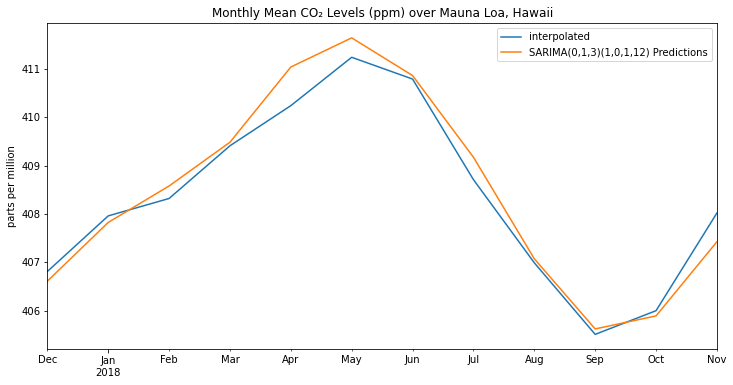

In [17]:
# Plot predictions against known values
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel=''

ax = test['interpolated'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

### Evaluate the Model

In [18]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test['interpolated'], predictions)
print(f'SARIMA(0,1,3)(1,0,1,12) MSE Error: {error:11.10}')

SARIMA(0,1,3)(1,0,1,12) MSE Error: 0.1279039797


In [19]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test['interpolated'], predictions)
print(f'SARIMA(0,1,3)(1,0,1,12) RMSE Error: {error:11.10}')

SARIMA(0,1,3)(1,0,1,12) RMSE Error: 0.3576366587


In [23]:
test['interpolated'].describe()

count     12.000000
mean     408.333333
std        1.838944
min      405.510000
25%      406.945000
50%      408.170000
75%      409.617500
max      411.240000
Name: interpolated, dtype: float64

### Retrain the model on the full data, and forecast the future

In [24]:
model = SARIMAX(df['interpolated'],order=(0,1,3),seasonal_order=(1,0,1,12))
results = model.fit()
fcast = results.predict(len(df),len(df)+50,typ='levels').rename('SARIMA(0,1,3)(1,0,1,12) Forecast')

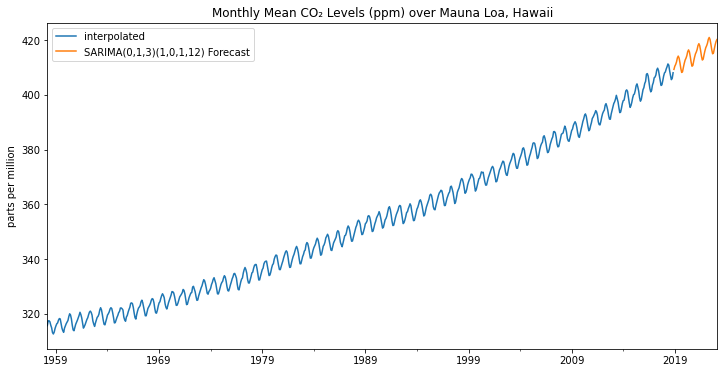

In [25]:
# Plot predictions against known values
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel=''

ax = df['interpolated'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

## Forecasting with RNN

In [26]:
df.index.freq = 'MS'

In [37]:
df = df[['interpolated']]
df.head()

,interpolated
date,
1958-03-01,315.71
1958-04-01,317.45
1958-05-01,317.50
1958-06-01,317.10
1958-07-01,315.86


In [47]:
train = train[['interpolated']]
test = test[['interpolated']]

## Scale Data

In [48]:
from sklearn.preprocessing import MinMaxScaler

In [49]:
scaler = MinMaxScaler()

In [50]:
scaler.fit(train)

MinMaxScaler()

In [51]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [52]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [73]:
n_features = 1
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [67]:
# What does the first batch look like?
X,y = generator[0]

In [68]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.03143358 0.04936618 0.04988148 0.04575904 0.03297949 0.02339483
 0.00556529 0.         0.00690508 0.02071524 0.03050603 0.03833866]
Predict this y: 
 [[0.04173967]]


### Create the Model

In [69]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [70]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [71]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [72]:
# fit model
model.fit_generator(generator,epochs=30)

Epoch 1/30
705/705 [==============================] - 4s 4ms/step - loss: 0.0205
Epoch 2/30
705/705 [==============================] - 3s 4ms/step - loss: 9.2947e-04
Epoch 3/30
705/705 [==============================] - 3s 4ms/step - loss: 0.0011
Epoch 4/30
705/705 [==============================] - 3s 4ms/step - loss: 0.0010
Epoch 5/30
705/705 [==============================] - 3s 4ms/step - loss: 7.2044e-04
Epoch 6/30
705/705 [==============================] - 3s 4ms/step - loss: 8.6687e-04
Epoch 7/30
705/705 [==============================] - 3s 4ms/step - loss: 6.3684e-04
Epoch 8/30
705/705 [==============================] - 3s 4ms/step - loss: 8.8707e-04
Epoch 9/30
705/705 [==============================] - 3s 4ms/step - loss: 4.3464e-04
Epoch 10/30
705/705 [==============================] - 3s 4ms/step - loss: 3.5911e-04
Epoch 11/30
705/705 [==============================] - 3s 4ms/step - loss: 2.4583e-04
Epoch 12/30
705/705 [==============================] - 3s 4ms/step - loss: 

In [74]:
model.history.history.keys()

dict_keys(['loss'])

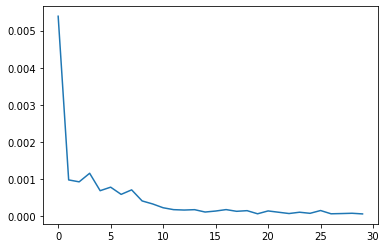

In [75]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch);

## Evaluate on Test Data

In [76]:
first_eval_batch = scaled_train[-12:]

In [77]:
first_eval_batch

array([[0.94599608],
       [0.96372256],
       [0.96671133],
       [0.97454396],
       [0.99330104],
       [1.        ],
       [0.99165207],
       [0.97351335],
       [0.95300423],
       [0.93486551],
       [0.93754509],
       [0.95290116]])

In [78]:
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))

In [79]:
model.predict(first_eval_batch)

array([[0.9735433]], dtype=float32)

In [80]:
scaled_test[0]

array([0.97031846])

In [81]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

In [82]:
current_batch.shape

(1, 12, 1)

In [83]:
current_batch

array([[[0.94599608],
        [0.96372256],
        [0.96671133],
        [0.97454396],
        [0.99330104],
        [1.        ],
        [0.99165207],
        [0.97351335],
        [0.95300423],
        [0.93486551],
        [0.93754509],
        [0.95290116]]])

In [84]:
np.append(current_batch[:,1:,:],[[[99]]],axis=1)

array([[[ 0.96372256],
        [ 0.96671133],
        [ 0.97454396],
        [ 0.99330104],
        [ 1.        ],
        [ 0.99165207],
        [ 0.97351335],
        [ 0.95300423],
        [ 0.93486551],
        [ 0.93754509],
        [ 0.95290116],
        [99.        ]]])

In [85]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [86]:
test_predictions

[array([0.9735433], dtype=float32),
 array([0.9934801], dtype=float32),
 array([1.0089066], dtype=float32),
 array([1.018367], dtype=float32),
 array([1.0209619], dtype=float32),
 array([1.0164769], dtype=float32),
 array([1.0061405], dtype=float32),
 array([0.9930344], dtype=float32),
 array([0.9815958], dtype=float32),
 array([0.97669244], dtype=float32),
 array([0.9808059], dtype=float32),
 array([0.9929384], dtype=float32)]

In [87]:
scaled_test

array([[0.97031846],
       [0.98217046],
       [0.98588066],
       [0.99711429],
       [1.00566835],
       [1.01597444],
       [1.0113367 ],
       [0.98990003],
       [0.97217355],
       [0.95692054],
       [0.96197052],
       [0.98278883]])

## Inverse Transformations and Compare

In [88]:
true_predictions = scaler.inverse_transform(test_predictions)

In [103]:
len(true_predictions)

12

In [90]:
test

,interpolated
date,
2017-12-01,406.81
2018-01-01,407.96
2018-02-01,408.32
2018-03-01,409.41
2018-04-01,410.24
2018-05-01,411.24
2018-06-01,410.79
2018-07-01,408.71
2018-08-01,406.99


In [91]:
# IGNORE WARNINGS
test['Predictions'] = true_predictions

In [92]:
test

,interpolated,Predictions
date,,
2017-12-01,406.81,407.122905
2018-01-01,407.96,409.057373
2018-02-01,408.32,410.554208
2018-03-01,409.41,411.472155
2018-04-01,410.24,411.723931
2018-05-01,411.24,411.288751
2018-06-01,410.79,410.285810
2018-07-01,408.71,409.014130
2018-08-01,406.99,407.904242


<AxesSubplot:xlabel='date'>

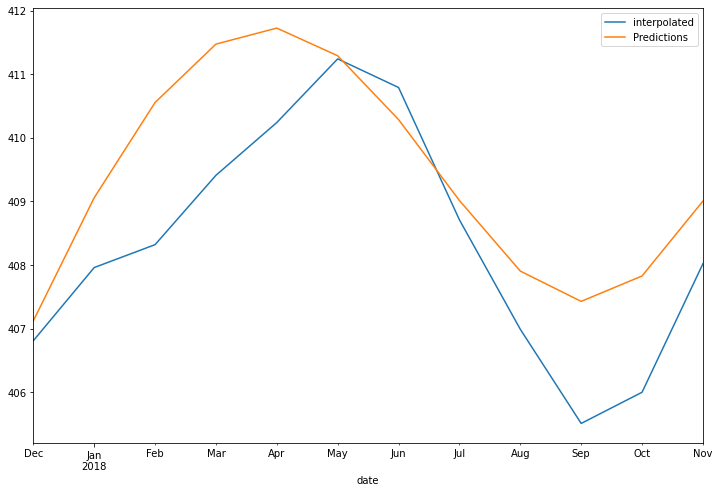

In [93]:
test.plot(figsize=(12,8))

In [94]:
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

In [95]:
test['interpolated'].describe()

count     12.000000
mean     408.333333
std        1.838944
min      405.510000
25%      406.945000
50%      408.170000
75%      409.617500
max      411.240000
Name: interpolated, dtype: float64

In [96]:
mean_squared_error(test['interpolated'], test['Predictions'])
rmse(test['interpolated'],  test['Predictions'])

1.3516578201537341

In [106]:
import pandas as pd
from datetime import datetime

idx = pd.date_range('2019-01-01', periods=12, freq='MS')
idx


DatetimeIndex(['2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
               '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
               '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01'],
              dtype='datetime64[ns]', freq='MS')

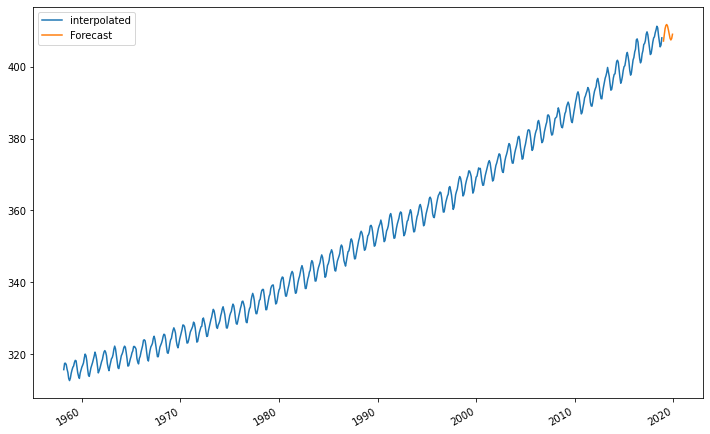

In [108]:
s = pd.DataFrame(np.array(true_predictions)[:12],idx)
s.columns = ['Forecast']
sd = [df,s]
final = pd.concat(sd)
forecast = final.plot(figsize=(12,8))

## Fcaebook Prophet Library

In [109]:
from fbprophet import Prophet

In [132]:
df = pd.read_csv('../Data/co2_mm_mlo.csv')
df['date']=pd.to_datetime(dict(year=df['year'], month=df['month'], day=1))
df = df[['date','interpolated']]

In [136]:
df.columns = ['ds','y']
df['ds'] = pd.to_datetime(df['ds'])
df

,ds,y
0,1958-03-01,315.71
1,1958-04-01,317.45
2,1958-05-01,317.50
3,1958-06-01,317.10
4,1958-07-01,315.86
...,...,...
724,2018-07-01,408.71
725,2018-08-01,406.99
726,2018-09-01,405.51
727,2018-10-01,406.00


In [158]:
# train =  train.reset_index()
# train.columns = ['ds','y']

# test =  test.reset_index()
test = test[['ds','y']]
train = train[['ds','y']]

In [159]:
m = Prophet()
m.fit(train)
future = m.make_future_dataframe(periods=12,freq='MS')
forecast = m.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


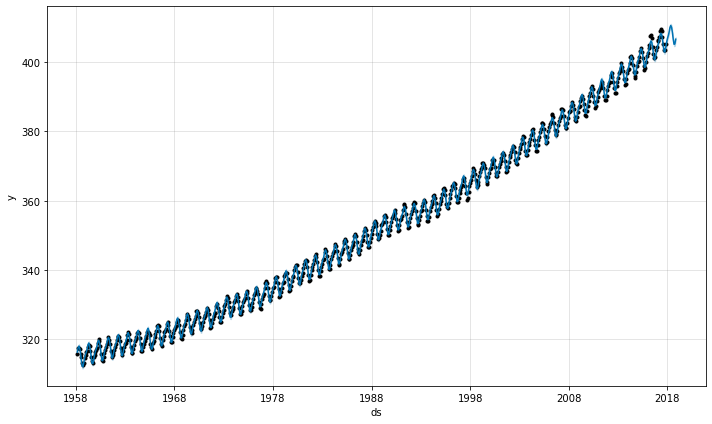

In [160]:
fig = m.plot(forecast)

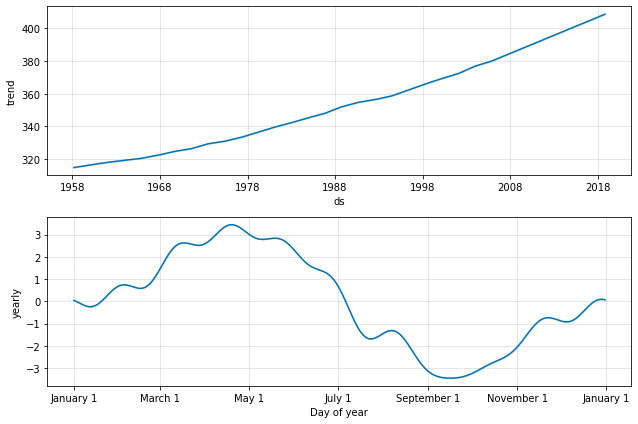

In [145]:
fig = m.plot_components(forecast)

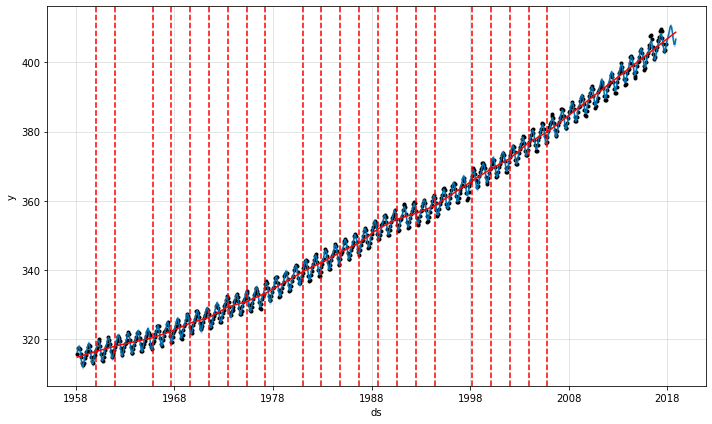

In [146]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


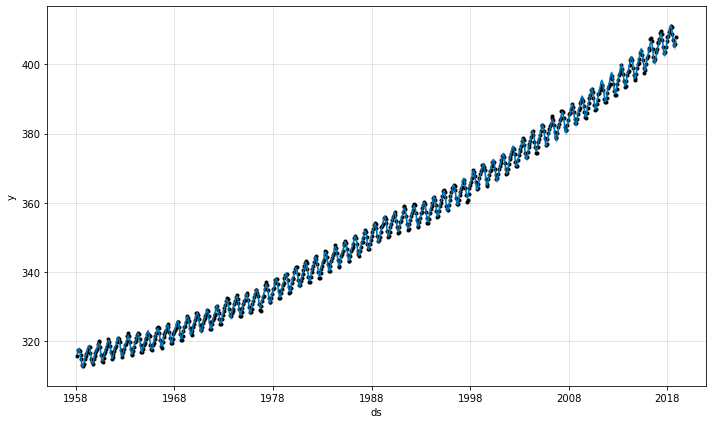

In [147]:
m = Prophet(seasonality_mode='multiplicative')
m.fit(df)
forecast = m.predict(future)
fig = m.plot(forecast)

In [148]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,1958-03-01,314.970137,315.726904,316.730958,314.970137,314.970137,0.003989,0.003989,0.003989,0.003989,0.003989,0.003989,0.0,0.0,0.0,316.226611
1,1958-04-01,315.040228,316.819195,317.839434,315.040228,315.040228,0.007246,0.007246,0.007246,0.007246,0.007246,0.007246,0.0,0.0,0.0,317.322882
2,1958-05-01,315.108058,317.241057,318.304454,315.108058,315.108058,0.008503,0.008503,0.008503,0.008503,0.008503,0.008503,0.0,0.0,0.0,317.787345
3,1958-06-01,315.178149,316.711113,317.761107,315.178149,315.178149,0.006503,0.006503,0.006503,0.006503,0.006503,0.006503,0.0,0.0,0.0,317.227610
4,1958-07-01,315.245979,315.290562,316.381417,315.245979,315.245979,0.001926,0.001926,0.001926,0.001926,0.001926,0.001926,0.0,0.0,0.0,315.853004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724,2018-07-01,408.214469,408.465763,409.521445,408.214469,408.214469,0.001926,0.001926,0.001926,0.001926,0.001926,0.001926,0.0,0.0,0.0,409.000510
725,2018-08-01,408.406261,406.169862,407.229489,408.406261,408.406261,-0.004186,-0.004186,-0.004186,-0.004186,-0.004186,-0.004186,0.0,0.0,0.0,406.696653
726,2018-09-01,408.598053,404.422744,405.463379,408.598053,408.598053,-0.008916,-0.008916,-0.008916,-0.008916,-0.008916,-0.008916,0.0,0.0,0.0,404.954917
727,2018-10-01,408.783658,404.534793,405.592151,408.783658,408.783658,-0.009149,-0.009149,-0.009149,-0.009149,-0.009149,-0.009149,0.0,0.0,0.0,405.043735


<AxesSubplot:xlabel='ds'>

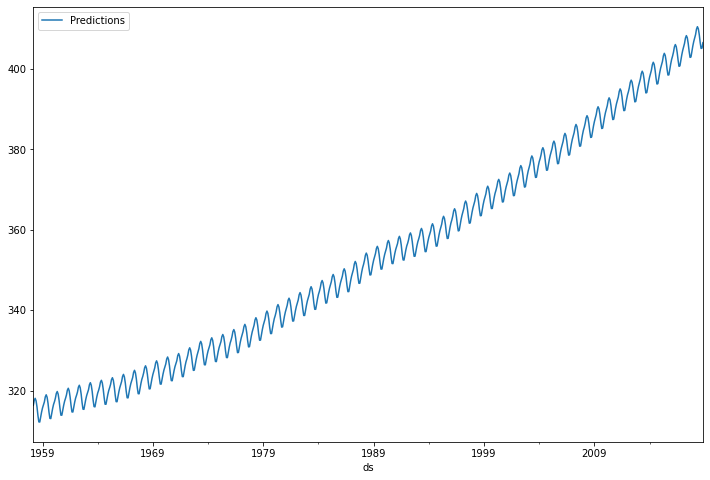

In [163]:
ax = forecast.plot(x='ds',y='yhat',label='Predictions',legend=True,figsize=(12,8))
ax
# test.plot(x='ds',y='y',label='True Miles',legend=True,ax=ax,xlim=('2018-01-01','2019-01-01'))

In [164]:
from statsmodels.tools.eval_measures import rmse

In [165]:
predictions = forecast.iloc[-12:]['yhat']

In [166]:
predictions

717    405.736171
718    406.858914
719    407.686772
720    408.592672
721    409.941608
722    410.561427
723    410.045346
724    408.624468
725    406.642761
726    405.144258
727    405.222765
728    406.593481
Name: yhat, dtype: float64

In [167]:
test['y']

0     407.122905
1     409.057373
2     410.554208
3     411.472155
4     411.723931
5     411.288751
6     410.285810
7     409.014130
8     407.904242
9     407.428467
10    407.827594
11    409.004813
Name: y, dtype: float64

In [168]:
rmse(predictions,test['y'])

1.9704863197009004

In [169]:
test.mean()

ds    408.333333
y     409.390365
dtype: float64

## RMSE For different models


### SARIMA(0,1,3)(1,0,1,12) RMSE Error: 0.3576366587

### RNN With LSTM RMSE Error: 1.351

### Facebook Prophet Library RMSE Error: 1.9704